# ResNets

> Can we beat 90% accuracy on FashionMNIST?

Adapted from:

- [https://www.youtube.com/watch?v=nlVOG2Nzc3k&t=3398s](https://www.youtube.com/watch?v=nlVOG2Nzc3k&t=3398s)

In [1]:
#| default_exp resnets

In [2]:
# |export
from functools import partial

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn.functional as F
from einops import rearrange
from IPython.display import Latex, Markdown, display
from torch import nn
from torch.nn import init
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification import MulticlassAccuracy

from slowai.activations import Hook, HooksCallback, set_seed
from slowai.learner import CancelFitException, DeviceCB, TrainLearner, fashion_mnist
from slowai.sgd import train_1cycle

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
set_seed(42)
plt.style.use("ggplot")

Let's start by cleaning up some of the module implementations.

In [75]:
# |export
class GeneralReLU(nn.Module):
    def __init__(self, a=0.1, b=0.4):
        """Generalized ReLU activation function with bias and leaky slope."""
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, x):
        if self.a:
            x = F.leaky_relu(x, self.a)
        else:
            x = F.relu(x)
        if self.b:
            x -= self.b
        return x


class Conv(nn.Conv2d):
    """Convolutional block with norms and activations"""

    def __init__(self, c_in, c_out, stride=2, ks=3, act=True, norm=True):
        super().__init__(
            c_in,
            c_out,
            stride=stride,
            kernel_size=ks,
            padding=ks // 2,
            bias=not norm,
        )
        self.norm = nn.BatchNorm2d(c_out) if norm else None
        self.act = GeneralReLU() if act else None

    def forward(self, x):
        x = super(Conv, self).forward(x)
        if self.act:
            x = self.act(x)
        if self.norm:
            x = self.norm(x)
        return x


def init_leaky_weights(module):
    if isinstance(module, Conv):
        if module.act is not None:
            init.kaiming_normal_(module.weight, a=module.act.a)
        else:
            init.kaiming_normal_(module.weight)


class CNN(nn.Module):
    """6 layer convolutional neural network with GeneralReLU"""

    def __init__(self, nfs=(8, 16, 32, 64), n_outputs=10, block=None):
        super().__init__()
        self.nfs = nfs
        self.n_outputs = n_outputs
        self.layers = nn.Sequential(*self.get_layers(nfs, n_outputs, block))

    def get_layers(self, nfs, n_outputs=10, C=None):
        if C is None:
            C = Conv
        assert len(nfs) == 4
        layers = [C(1, 8, ks=5)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            layers.append(C(c_in, c_out))
        layers.append(C(nfs[-1], n_outputs, act=False))
        return layers

    def forward(self, x):
        x = self.layers(x)
        bs, c, w, h = x.shape
        assert c == self.n_outputs
        assert w == h == 1
        return rearrange(x, "bs c w h -> bs (c w h)")

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights)
        return model

In [76]:
_, stats = train_1cycle(CNN.kaiming(nfs=(8, 16, 32, 64)))


KeyboardInterrupt



In [ ]:
stats.mean_std_plot()

## Going deeper

At this point, we can try to go deeper by adding a stride 1 convolution layer

In [77]:
class DeeperCNN(CNN):
    """7 layer convolutional neural network with GeneralReLU"""

    def get_layers(self, nfs, n_outputs=10, C=None):
        if C is None:
            C = Conv
        assert len(nfs) == 5
        # Notice we changed the stride to 1 to fit another layer --+
        layers = [C(1, 8, ks=5, stride=1)]  # 👈 ------------------+
        for c_in, c_out in zip(nfs, nfs[1:]):
            layers.append(C(c_in, c_out))
        layers.append(C(nfs[-1], n_outputs, act=False))
        return layers

MulticlassAccuracy,loss,epoch,train
0.783,0.764,0,train
0.818,0.544,0,eval
0.885,0.364,1,train
0.873,0.366,1,eval
0.913,0.271,2,train
0.895,0.314,2,eval


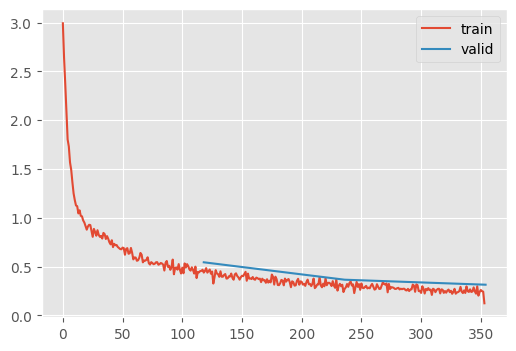

In [78]:
train_1cycle(DeeperCNN.kaiming(nfs=(8, 16, 32, 64, 128)));

This gives us 90% in 3 epochs, which is the quickest we've been able to achieve that accuracy.

We want to make our networks wider and deeper, but this has a limit even with an apropriate initialization. In "Deep Residual Learning for Image Recognition," Kaiming observed that a 56 layer network had worse performance than a 20 layer network. Why?

Notice, if the 36 extra layers were $I$, it should have the same performance of the smaller network. In other words, it's a superset of the small network. We should be able to table advantage of the initial training dynamics of the shallower network with deeper networks with **Skip Connections**.

![](https://upload.wikimedia.org/wikipedia/commons/b/ba/ResBlock.png)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, inner):
        self.inner = inner

    def forward(self, x):
        x_orig = x
        x = self.inner(x)
        assert x.shape == x_orig.shape
        return x + x_orig

Note that the shape must not change after the inner transformation. To do so with a Convolutional Neural Network, we need a very simple "Identity" convolution that does the same transformation.

In [7]:
F.avg_pool2d?

Docstring:
avg_pool2d(input, kernel_size, stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None) -> Tensor

Applies 2D average-pooling operation in :math:`kH \times kW` regions by step size
:math:`sH \times sW` steps. The number of output features is equal to the number of
input planes.

See :class:`~torch.nn.AvgPool2d` for details and output shape.

Args:
    input: input tensor :math:`(\text{minibatch} , \text{in\_channels} , iH , iW)`
    kernel_size: size of the pooling region. Can be a single number or a
      tuple `(kH, kW)`
    stride: stride of the pooling operation. Can be a single number or a
      tuple `(sH, sW)`. Default: :attr:`kernel_size`
    padding: implicit zero paddings on both sides of the input. Can be a
      single number or a tuple `(padH, padW)`. Default: 0
    ceil_mode: when True, will use `ceil` instead of `floor` in the formula
        to compute the output shape. Default: ``False``
    count_include_pad: when True, will i

In [97]:
# |export
class ResidualConvBlock(nn.Module):
    """Convolutional block with residual links"""

    def __init__(self, c_in, c_out, stride=2, ks=3, act=True, norm=True):
        super().__init__()
        self.conv_a = Conv(c_in, c_out, stride=1, ks=ks, act=act, norm=norm)
        self.conv_b = Conv(c_out, c_out, stride=stride, ks=ks, act=False, norm=norm)
        self.id_conv = nn.Conv2d(c_in, c_out, stride=1, kernel_size=1)
        self.act = GeneralReLU() if act else None

    def forward(self, x):
        x_orig = x.clone()
        # Downsample the original, if neccesary
        if self.conv_b.stride == (2, 2):
            x_orig = F.avg_pool2d(x_orig, kernel_size=2, ceil_mode=True)
        elif self.conv_b.stride[0] > 2 or self.conv_b.stride[1] > 2:
            raise ValueError
        else:
            assert self.conv_b.stride == (1, 1)
        # Add extra channels, if neccesary
        if self.conv_a.in_channels != self.conv_b.out_channels:
            x_orig = self.id_conv(x_orig)
        x = self.conv_a(x)
        x = self.conv_b(x)
        x += x_orig
        if self.act:
            x = self.act(x)
        return x

MulticlassAccuracy,loss,epoch,train
0.807,0.583,0,train
0.869,0.384,0,eval
0.894,0.289,1,train
0.893,0.288,1,eval
0.926,0.201,2,train
0.915,0.228,2,eval


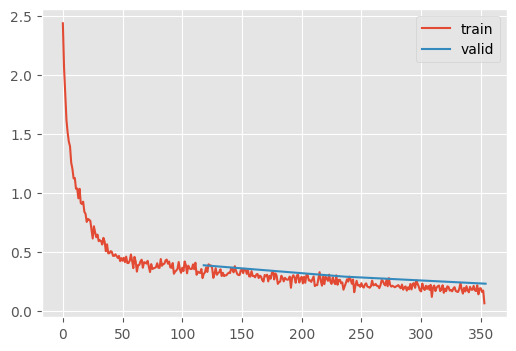

In [98]:
m = DeeperCNN.kaiming(nfs=(8, 16, 32, 64, 128), block=ResidualConvBlock)
_ = train_1cycle(m)

Recall, the previous best was %90.9 after 5 epochs 🥳

Let's take a closer look at how the parameters are allocated

In [164]:
# |export
class SummaryCB(HooksCallback):
    """Summarize the model"""

    def __init__(self, mods=None, mod_filter=fc.noop):
        super().__init__(hook_cls=partial(Hook, f=self.shape))
        self.mods = mods
        self.mod_filter = fc.noop
        self.total = 0
        self.lines = [
            "| Type | Input | Output | N. params | MFlops |",
            "| -- | -- | -- | -- | -- |",
        ]

    def flops(self, x, w, h):
        """Estimate flops"""
        if x.dim() < 3:
            return x.numel()
        else:
            return x.numel() * w * h

    def shape(self, hook, module, input_, output_):
        i, o = input_[0], output_[0]
        *_, h, w = o.shape
        np = sum(p.numel() for p in module.parameters())
        self.total += np
        flops = sum(self.flops(p, h, w) for p in module.parameters()) / 1e6
        l = f"| {type(module).__name__} | {tuple(i.shape)} | {tuple(o.shape)} | {np:,} | {flops:.1f}"
        self.lines.append(l)

    def after_batch(self, learn):
        self.lines.append(f"| Total | | | {self.total:,} | |")
        display(Markdown("\n".join(self.lines)))
        self.cleanup_fit(learn)
        raise CancelFitException

In [169]:
# |export
def summarize(m, mods, dls=fashion_mnist(512)):
    TrainLearner(
        m,
        dls,
        F.cross_entropy,
        lr=0.0,
        cbs=[SummaryCB(mods=mods), DeviceCB()],
        opt_func=torch.optim.AdamW,
    ).fit()

In [170]:
for block in [Conv, ResidualConvBlock]:
    print(block.__name__)
    m = DeeperCNN.kaiming(nfs=(8, 16, 32, 64, 128), block=block)
    summarize(m, m.layers)

Conv


| Type | Input | Output | N. params | MFlops |
| -- | -- | -- | -- | -- |
| Conv | (512, 1, 28, 28) | (8, 28, 28) | 216 | 0.2
| Conv | (512, 8, 28, 28) | (16, 14, 14) | 1,184 | 0.2
| Conv | (512, 16, 14, 14) | (32, 7, 7) | 4,672 | 0.2
| Conv | (512, 32, 7, 7) | (64, 4, 4) | 18,560 | 0.3
| Conv | (512, 64, 4, 4) | (128, 2, 2) | 73,984 | 0.3
| Conv | (512, 128, 2, 2) | (10, 1, 1) | 11,540 | 0.0
| Total | | | 110,156 | |

ResidualConvBlock


| Type | Input | Output | N. params | MFlops |
| -- | -- | -- | -- | -- |
| ResidualConvBlock | (512, 1, 28, 28) | (8, 28, 28) | 1,848 | 1.4
| ResidualConvBlock | (512, 8, 28, 28) | (16, 14, 14) | 3,664 | 0.7
| ResidualConvBlock | (512, 16, 14, 14) | (32, 7, 7) | 14,496 | 0.7
| ResidualConvBlock | (512, 32, 7, 7) | (64, 4, 4) | 57,664 | 0.9
| ResidualConvBlock | (512, 64, 4, 4) | (128, 2, 2) | 230,016 | 0.9
| ResidualConvBlock | (512, 128, 2, 2) | (10, 1, 1) | 13,750 | 0.0
| Total | | | 321,438 | |

Indeed, we have almost 3x as many paramters and the training dynamics are quite stable!

How does this compare to a standard implementation?

In [119]:
def train_timm(id):
    m = timm.create_model(id, in_chans=1, num_classes=10)
    m.layers = []  # Because we're not recording anything
    np = sum(p.numel() for p in m.parameters())
    print(f"N. parameters: {np:,}")
    train_1cycle(m)

N. parameters: 11,175,370


MulticlassAccuracy,loss,epoch,train
0.776,0.663,0,train
0.729,0.935,0,eval
0.884,0.312,1,train
0.890,0.316,1,eval
0.914,0.230,2,train
0.906,0.260,2,eval


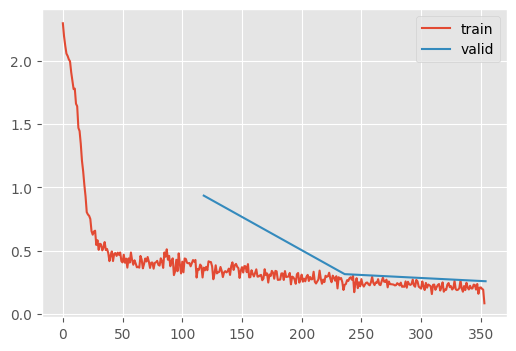

In [121]:
train_timm("resnet18")

Slightly better! Of course, this model has 30x more parameters, so it's not surprising.

How does this compare to a network without these links?

In [122]:
class DoubleConvBlock(nn.Module):
    """Convolutional block with residual links"""

    def __init__(self, c_in, c_out, stride=2, ks=3, act=True, norm=True):
        super().__init__()
        self.conv_a = Conv(c_in, c_out, stride=1, ks=ks, act=act, norm=norm)
        self.conv_b = Conv(c_out, c_out, stride=stride, ks=ks, act=act, norm=norm)

    def forward(self, x):
        x = self.conv_a(x)
        x = self.conv_b(x)
        return x

In [125]:
m = DeeperCNN.kaiming(nfs=(8, 16, 32, 64, 128), block=DoubleConvBlock)

In [126]:
shape(m)

| Type | Input | Output | N. params
| -- | -- | -- | -- |
| DoubleConvBlock | (512, 1, 28, 28) | (8, 28, 28) | 1,832
| DoubleConvBlock | (512, 8, 28, 28) | (16, 14, 14) | 3,520
| DoubleConvBlock | (512, 16, 14, 14) | (32, 7, 7) | 13,952
| DoubleConvBlock | (512, 32, 7, 7) | (64, 4, 4) | 55,552
| DoubleConvBlock | (512, 64, 4, 4) | (128, 2, 2) | 221,696
| DoubleConvBlock | (512, 128, 2, 2) | (10, 1, 1) | 12,460
| Total | | | 309,012 |

MulticlassAccuracy,loss,epoch,train
0.793,0.730,0,train
0.806,0.599,0,eval
0.889,0.348,1,train
0.898,0.304,1,eval
0.920,0.247,2,train
0.910,0.275,2,eval


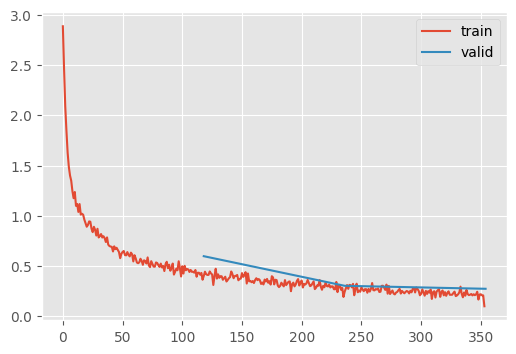

In [123]:
_ = train_1cycle(m)

Interestingly, only the slightest bit worse

In [171]:
#| hide
import nbdev

nbdev.nbdev_export()